In [65]:
# magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [479]:
# Custom functions and tools 
import sys
sys.path.insert(1, '../../dipper')

import tools as my_tools
import dipper as dip_pipeline
import models as dip_models
from evaluate import evaluate as evaluate
import gpmcmc as gp_my_data

In [480]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')

In [481]:
time = np.linspace(-100, 100, 150) + np.random.normal(2, 140, 150)
time = time[np.argsort(time)]
model = dip_models.skew_norm(time, -155, 5, 0, 16, 0.1) + np.random.normal(0, 0.001, len(time))
model_err = abs(np.random.normal(0.001, 0.001, 150))

<ErrorbarContainer object of 3 artists>

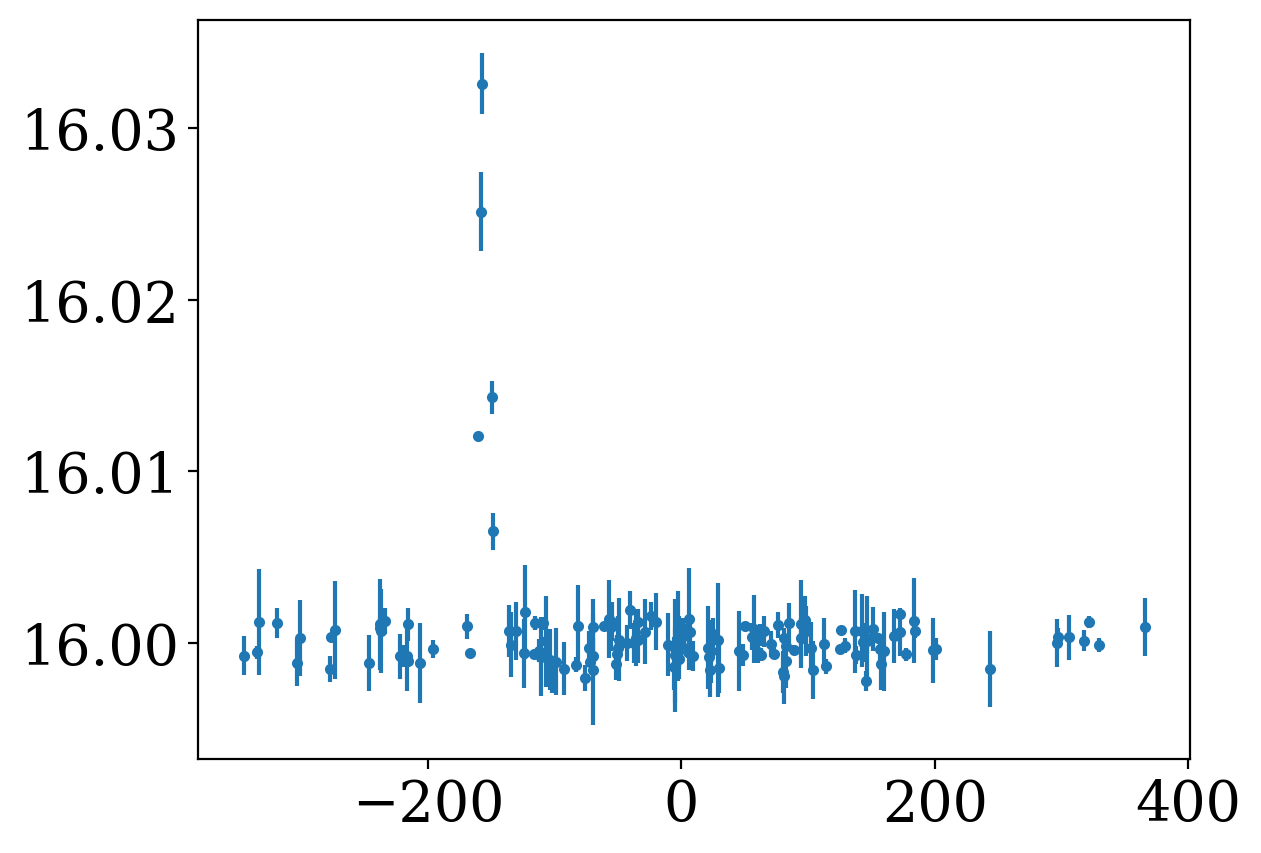

In [482]:
plt.errorbar(time, model, model_err, fmt='.')

## Simple GP with Minimziation

In [ ]:
gp1 = gp_my_data.simple_GP(time, model, model_err, Niter=1)

In [486]:
gp3 = gp_my_data.simple_GP(time, model, model_err, Niter=3) # number of minimization iterations won't make the fit any better....

Text(0, 0.5, 'Mag')

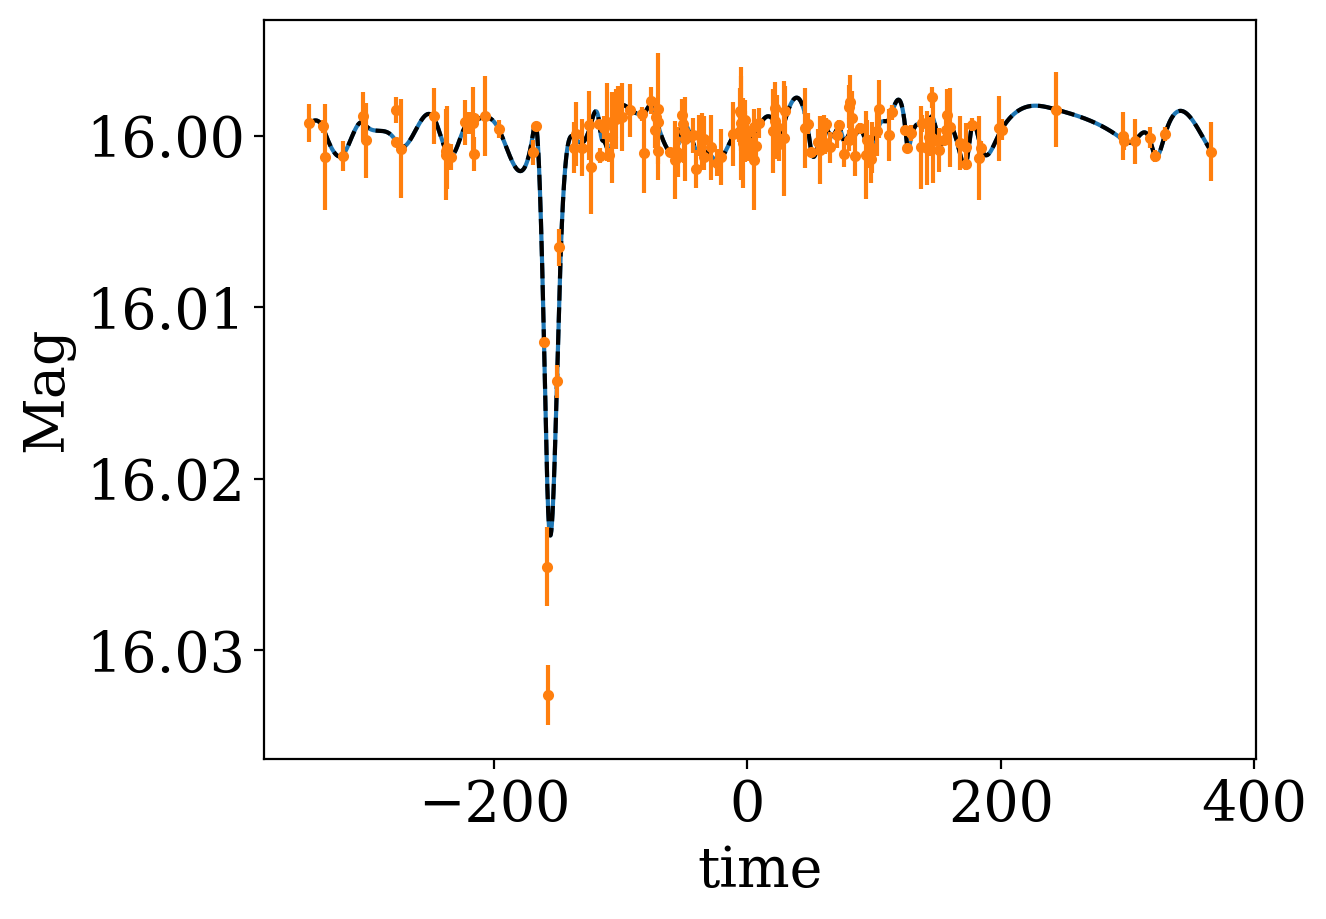

In [490]:
plt.plot(gp3[0], gp3[1], ls='-')
plt.plot(gp1[0], gp1[1], color='k', ls='--')
plt.errorbar(time, model, model_err, fmt='.')
plt.ylim(plt.ylim()[::-1])
plt.xlabel("time")
plt.ylabel("Mag")


In [406]:
def get_value(t, amp, location, sigma, log_sigma2): 
    return amp * np.exp(-0.5*(t.flatten()-location)**2/(sigma**2) * np.exp(-log_sigma2))

In [407]:
init = dict(amp=1, location=0, sigma=30, log_sigma2=1)

In [408]:
gpx = gp_my_data.model_gp_minimize(time, model, model_err, -250, 0, init)

In [409]:
gpx[-1].x

array([ 6.21932528e-03,  2.37480977e-01,  5.00000000e+00, -1.29669510e-09,
        2.49708662e+00,  1.00000000e+01])

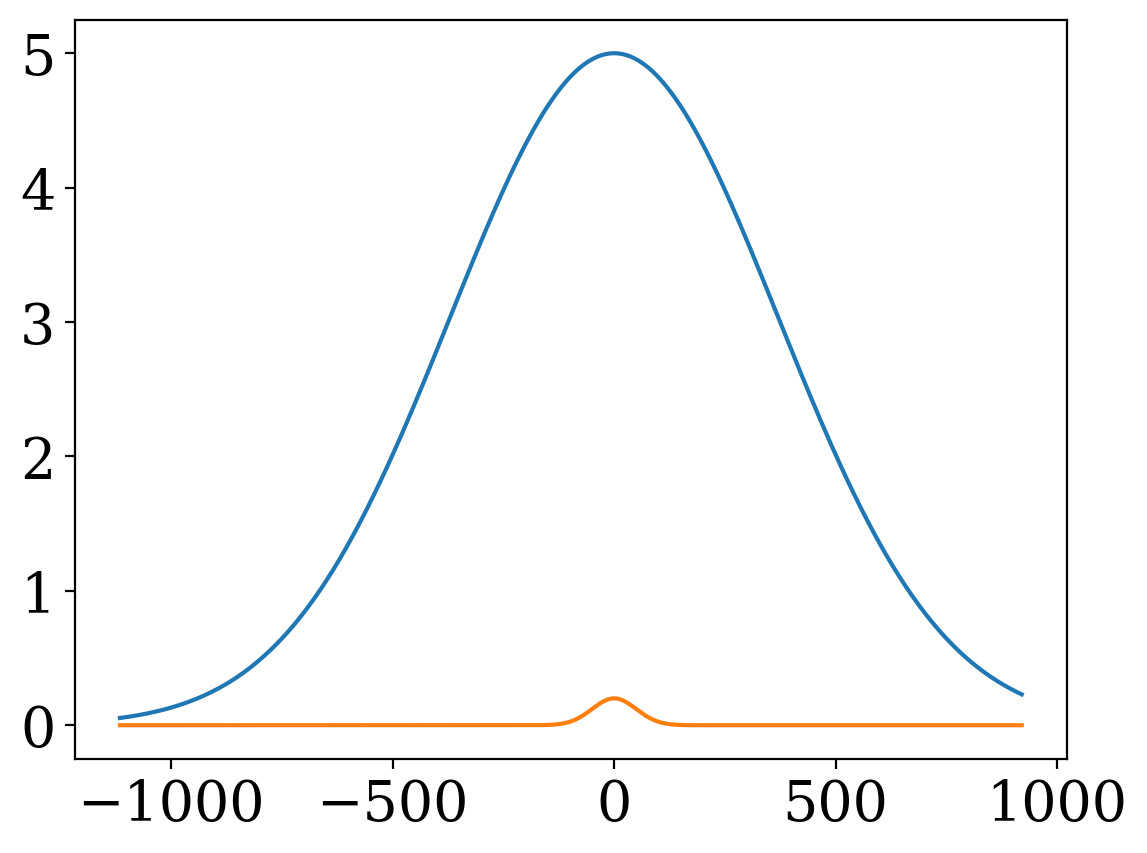

In [410]:
xx = np.linspace(min(time), max(time), 1000)
plt.plot(xx, get_value(xx, *gpx[-1].x[2::]))
plt.plot(xx, get_value(xx, 0.2, 0, 30, 1))

<ErrorbarContainer object of 3 artists>

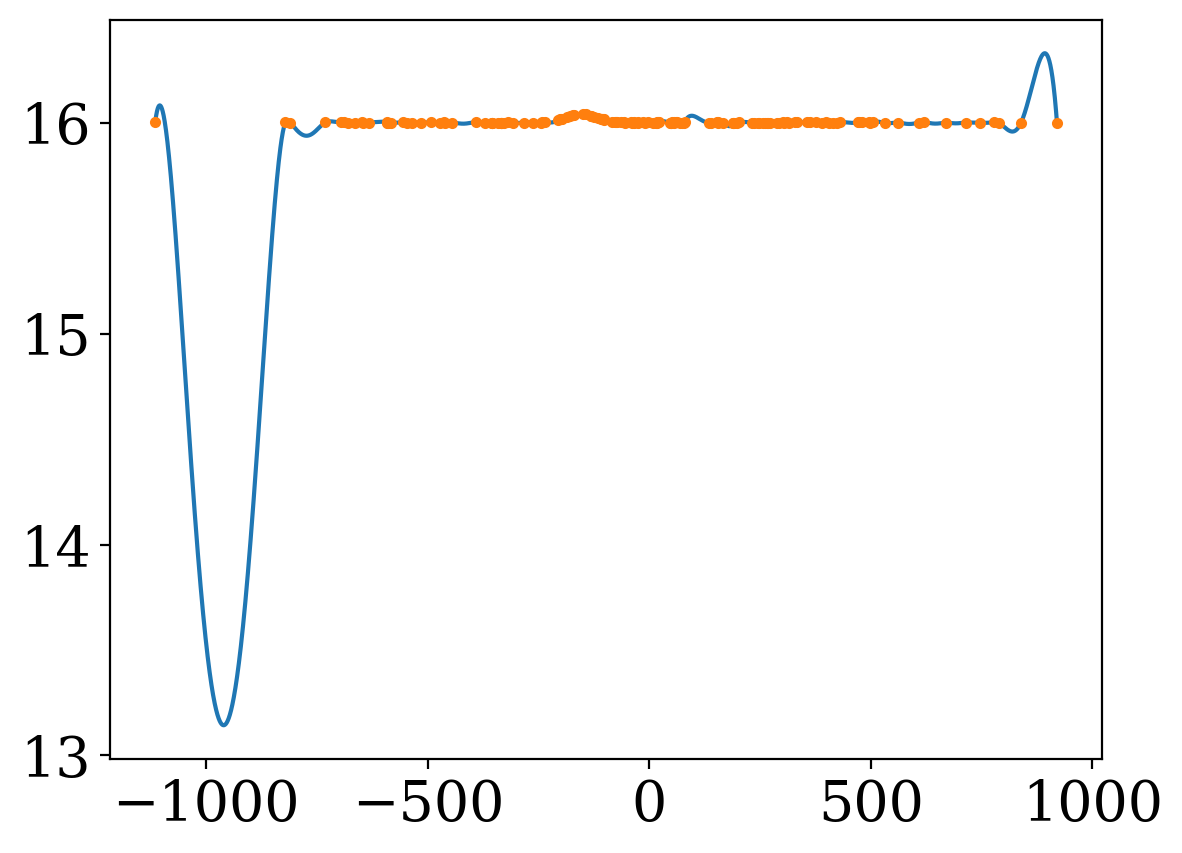

In [411]:
plt.plot(gpx[0], gpx[1])
plt.errorbar(time, model, model_err, fmt='.')

